# stardist cell segmentation

In [1]:
import zarr
import dask.array as da
import numpy as np
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
from snakebids import generate_inputs
import seaborn as sns
from stardist.models import StarDist2D


2024-02-19 19:16:29.093941: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-19 19:16:29.659269: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 19:16:29.659489: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 19:16:29.773784: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 19:16:30.009046: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-19 19:16:30.011913: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
in_zarr_pattern = '/cifs/prado/Kelly/data/lightsheet/bids/test_bids/sub-{subject}/micr/sub-{subject}_sample-brain_acq-{acq}_spim.ome.zarr.zip'
in_zarr = in_zarr_pattern.format(subject=subject, acq=acq)

In [7]:
from stardist.models import StarDist2D

# prints a list of available models
StarDist2D.from_pretrained()

# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


Text(0.5, 1.0, 'prediction + input overlay')

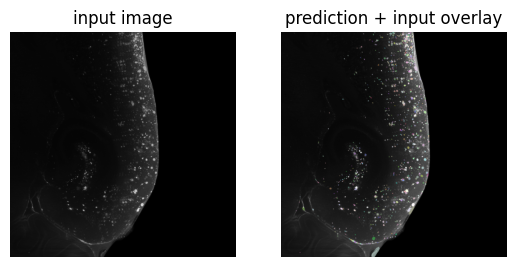

In [39]:
#try running the model on a slice
from stardist.plot import render_label
from csbdeep.utils import normalize
import matplotlib.pyplot as plt

darr = da.from_zarr(zarr_abeta,component='/0')
img = darr[30,3000:5000,3000:5000].squeeze().compute()

labels, details = model.predict_instances(normalize(img))

plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(render_label(labels, img=img))
plt.axis("off")
plt.title("prediction + input overlay")

In [21]:
#coords are the coordinates of polygons
#points are the centroids
#prob are the probabilities for each instance

print(details['coord'].shape)
print(details['points'].shape)
print(details['prob'].shape)


(543, 2, 32)
(543, 2)
(543,)


In [22]:
details['coord'][:,1].max()

514.5545

In [23]:
max_intensity=60000

#now let's try with dask
def stardist_2d(x):
    labels,_=model.predict_instances(np.clip(x.reshape((x.shape[1],x.shape[2]))/max_intensity,0,1))
    return (labels>0).reshape(x.shape)
    


In [40]:
#darr_labelled = darr[800:801,:,:].rechunk((1,chunkdim,chunkdim)).map_blocks(stardist_2d,dtype='uint8')
darr_labelled = darr[:,:,:].map_blocks(stardist_2d,dtype='uint8')
#darr_labelled = darr[800:801,:,:].map_blocks(stardist_2d,dtype='uint16')



In [41]:
with ProgressBar():
    darr_labelled.to_zarr('stardisk_labels.zarr',
                          overwrite=True,
                          storage_options={'dimension_separator':'/'})
    #arr_labelled = darr_labelled.compute()

[########################################] | 100% Completed | 18m 54s


In [53]:
darr_labels = da.from_zarr('stardisk_labels.zarr',component='/').astype('bool')
darr_labels

dask.array<astype, shape=(67, 7169, 6049), dtype=bool, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>

In [19]:
#write to ome-zarr:
import pandas as pd
from ome_zarr.writer import write_labels, write_label_metadata
from ome_zarr.scale import Scaler

in_img_zarr = zarr_abeta
in_label_tsv = 'labels_desc-binary_dseg.tsv'
level=0
in_label_zarr = 'stardisk_labels.zarr'
out_ome_zarr = 'img_with_labels.ome.zarr'
in_label_name = 'stardist'

#read labels
darr_labels = da.from_zarr('stardisk_labels.zarr',component='/')

#read coordinate transform from ome-zarr
zi = zarr.open(in_img_zarr)
attrs=zi['/'].attrs.asdict()
multiscale=0 #first multiscale image
multiscale_datasets = attrs['multiscales'][multiscale]['datasets']
max_layer=len(multiscale_datasets)

print(multiscale_datasets)
print(max_layer)

#for writing metadata:
axes = attrs['multiscales'][multiscale]['axes']
axes = axes[-3:] #keep only the zyx axes, not channel if it exists

coordinate_transformations = [ multiscale_datasets[level]['coordinateTransformations'] for level in range(level,max_layer)]


#write ome-zarr metadata
store = zarr.DirectoryStore(out_ome_zarr,dimension_separator='/')

#first, copy entire input image (ie channel data) to the output zarr, 
# as that is needed alongside the labels to visualize
root_in = zi['/']
root = zarr.group(store,path='/',overwrite=True)

#then we add in labels
scaler = Scaler(max_layer=max_layer-level-1,method='nearest')

#label metadata - convert from bids tsv to list of dicts
df = pd.read_csv(in_label_tsv,sep='\t',index_col='index')

label_metadata={'colors':[],
               'properties':[]}

for i, row in df.iterrows():
    if i>0: #ensure bg label is transparent
        alpha=255
    else:
        alpha=0

    hexrgb=row['color'].lstrip("#")
    rgba = [int(hexrgb[i:i+2], 16) for i in (0, 2, 4)]
    rgba.append(alpha)
    label_metadata['colors'].append({'label-value': i, 'rgba': tuple(rgba)})
    label_metadata['properties'].append({'label-value': i, 'name': row['name'], 'abbreviation': row['abbreviation']})  

[{'coordinateTransformations': [{'scale': [0.1, 0.0027083330000000003, 0.0027083330000000003], 'type': 'scale'}], 'path': '0'}, {'coordinateTransformations': [{'scale': [0.1, 0.0054166660000000005, 0.0054166660000000005], 'type': 'scale'}], 'path': '1'}, {'coordinateTransformations': [{'scale': [0.1, 0.010833332000000001, 0.010833332000000001], 'type': 'scale'}], 'path': '2'}, {'coordinateTransformations': [{'scale': [0.1, 0.021666664000000002, 0.021666664000000002], 'type': 'scale'}], 'path': '3'}, {'coordinateTransformations': [{'scale': [0.1, 0.043333328000000004, 0.043333328000000004], 'type': 'scale'}], 'path': '4'}]
5


In [14]:
#write stardist binary label as multiscale fieldfrac instead:

#write to ome-zarr:
import pandas as pd
from ome_zarr.writer import write_image
from ome_zarr.scale import Scaler

in_img_zarr = zarr_abeta
level=0
in_label_zarr = 'stardisk_labels.zarr'
out_ome_zarr = 'img_with_fieldfrac.ome.zarr'

#read labels
darr_labels = da.from_zarr('stardisk_labels.zarr',component='/')

#read coordinate transform from ome-zarr
zi = zarr.open(in_img_zarr)
attrs=zi['/'].attrs.asdict()
multiscale=0 #first multiscale image
multiscale_datasets = attrs['multiscales'][multiscale]['datasets']
max_layer=len(multiscale_datasets)

print(multiscale_datasets)
print(max_layer)

#for writing metadata:
axes = attrs['multiscales'][multiscale]['axes']
axes = axes[-3:] #keep only the zyx axes, not channel if it exists

coordinate_transformations = [ multiscale_datasets[level]['coordinateTransformations'] for level in range(level,max_layer)]


#write ome-zarr metadata
store = zarr.DirectoryStore(out_ome_zarr,dimension_separator='/')


root = zarr.group(store,path='/',overwrite=True)

#then we add in labels but not as labels, just an image with float
scaler = Scaler(max_layer=max_layer-level-1,method='local_mean')


[{'coordinateTransformations': [{'scale': [0.1, 0.0027083330000000003, 0.0027083330000000003], 'type': 'scale'}], 'path': '0'}, {'coordinateTransformations': [{'scale': [0.1, 0.0054166660000000005, 0.0054166660000000005], 'type': 'scale'}], 'path': '1'}, {'coordinateTransformations': [{'scale': [0.1, 0.010833332000000001, 0.010833332000000001], 'type': 'scale'}], 'path': '2'}, {'coordinateTransformations': [{'scale': [0.1, 0.021666664000000002, 0.021666664000000002], 'type': 'scale'}], 'path': '3'}, {'coordinateTransformations': [{'scale': [0.1, 0.043333328000000004, 0.043333328000000004], 'type': 'scale'}], 'path': '4'}]
5


In [15]:
with ProgressBar():
    #zarr.copy_all(root_in,root)
    write_image(image=darr_labels.astype('float16'),
                            group=root,
                            scaler=scaler,
                            coordinate_transformations=coordinate_transformations,
                            storage_options={'dimension_separator': '/'},
                            axes=axes)


#  could make a script zarr to label zarr -- add label to ome zarr
 #- takes in img ome-zarr, label zarr, writes img+label ome zarr
  # opt params for label level 
  # cccccccccccccould take in nifti label too
  #

  #for each label provide: image (nii or zarr), label_tsv (bids format), ref zarr
 #could also take in images not just labels-- in this case would need to name them and put in group
    

[########################################] | 100% Completed | 35.36 s


In [6]:
zatlas=zarr.open('spimquant/work/sub-mouse1/micr/sub-mouse1_sample-brain_acq-1x_stain-autof_from-ABAv3_desc-resampled_dseg.ome.zarr')
label_indices=[d['label-value'] for d in zatlas['/labels/dseg'].attrs.asdict()['image-label']['colors']]
label_indices=label_indices[1:] #drop zero

In [5]:
#calc total positive pixels in each atlas region
from dask_image.ndmeasure import labeled_comprehension, sum_labels
from dask_image.ndmeasure import mean as mean_over_labels

#read labels
darr_stardist = da.from_zarr('stardisk_labels.zarr',component='/')
darr_atlas = da.from_zarr('spimquant/work/sub-mouse1/micr/sub-mouse1_sample-brain_acq-1x_stain-autof_from-ABAv3_desc-resampled_dseg.ome.zarr',
                             component='/labels/dseg/0')
"""
def count_pixels(x):
    return sum(x[:]>0)

result = labeled_comprehension(image=darr_stardist,
                               label_image=darr_atlas,
                               index=label_indices, 
                               func=count_pixels,
                               out_dtype='int16',
                               default=0)
"""
result=mean_over_labels(image=darr_stardist,
                               label_image=darr_atlas,
                               index=label_indices)

NameError: name 'label_indices' is not defined

In [178]:
with ProgressBar():
    arr_result=result.compute()

[                                        ] | 0% Completed | 240.80 ss


KeyboardInterrupt: 

In [106]:
from dask_image.ndmeasure import labeled_comprehension, sum_labels, find_objects

darr_atlas_ds16 = da.from_zarr('spimquant/work/sub-mouse1/micr/sub-mouse1_sample-brain_acq-1x_stain-autof_from-ABAv3_desc-resampled_dseg.ome.zarr',
                             component='/labels/dseg/4')

with ProgressBar():
    df_bboxes = find_objects(darr_atlas_ds16).compute()

df_bboxes

[########################################] | 100% Completed | 78.91 ss


,0,1,2
1,"slice(0, 65, None)","slice(34, 305, None)","slice(22, 272, None)"
2,"slice(0, 67, None)","slice(33, 302, None)","slice(23, 273, None)"
3,"slice(0, 67, None)","slice(77, 372, None)","slice(23, 273, None)"
4,"slice(0, 67, None)","slice(33, 370, None)","slice(22, 273, None)"
5,"slice(1, 67, None)","slice(35, 335, None)","slice(22, 273, None)"
...,...,...,...
1298,"slice(17, 50, None)","slice(174, 346, None)","slice(66, 214, None)"
1299,"slice(15, 64, None)","slice(163, 347, None)","slice(67, 214, None)"
1300,"slice(18, 51, None)","slice(233, 348, None)","slice(67, 213, None)"
1301,"slice(31, 52, None)","slice(293, 348, None)","slice(66, 212, None)"


In [105]:
#now we have bounding boxes for the level-4 atlas labels
# we just adjust them (multiply x and y by 16) to get bboxes for level-0 labels
ds_level=4
scaling=2 ** ds_level

for i in range(len(df_bboxes)):
    df_bboxes.iloc[i][1] = slice(df_bboxes.iloc[i][1].start*scaling,df_bboxes.iloc[i][1].stop*scaling)
    df_bboxes.iloc[i][2] = slice(df_bboxes.iloc[i][2].start*scaling,df_bboxes.iloc[i][2].stop*scaling)

df_bboxes

2681215160.py (7): ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2681215160.py (8): ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-

,0,1,2
1,"slice(0, 65, None)","slice(8704, 78080, None)","slice(8704, 78080, None)"
2,"slice(0, 67, None)","slice(8448, 77312, None)","slice(8448, 77312, None)"
3,"slice(0, 67, None)","slice(19712, 95232, None)","slice(19712, 95232, None)"
4,"slice(0, 67, None)","slice(8448, 94720, None)","slice(8448, 94720, None)"
5,"slice(1, 67, None)","slice(8960, 85760, None)","slice(8960, 85760, None)"
...,...,...,...
1298,"slice(17, 50, None)","slice(44544, 88576, None)","slice(44544, 88576, None)"
1299,"slice(15, 64, None)","slice(41728, 88832, None)","slice(41728, 88832, None)"
1300,"slice(18, 51, None)","slice(59648, 89088, None)","slice(59648, 89088, None)"
1301,"slice(31, 52, None)","slice(75008, 89088, None)","slice(75008, 89088, None)"


In [101]:
a

slice(0, 65, None)

In [102]:
b=slice(a.start*16,a.stop*16)
b

slice(0, 1040, None)

<BarContainer object of 1326 artists>

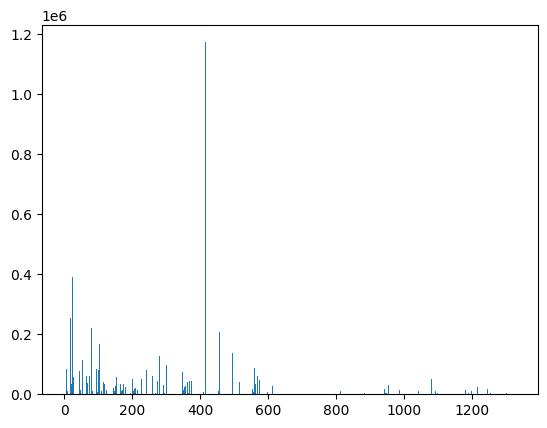

In [111]:
plt.bar(x=label_indices,height=arr_result)

In [56]:
from skimage.transform import rescale
in_chunksize=(1,16,16)

darr_labels_ds = darr_labels.map_blocks(lambda x: rescale(x,(1,16,16)),chunks=(1,int(1024/16),int(1024/16)))
darr_labels_ds

dask.array<lambda, shape=(67, 512, 384), dtype=bool, chunksize=(1, 64, 64), chunktype=numpy.ndarray>

In [ ]:
#calculated sum of voxels, not normalized by volume of ROI ---
# so get volumes so we can normalize
from skimage.measure import regionprops_table

region_properties = regionprops_table(darr_atlas_ds16.compute(),
                                     properties=['label','num_pixels'])
region_properties
#scale num_pixels by 16x16 to get equivalent num_pixels for level-0 (instead of level-4)
region_properties['num_pixels'] = 16*16*region_properties['num_pixels'].astype('float32')

In [172]:
#add zero to the mappings from label to posvox, and label to allvox
map_lbl_to_posvox = np.insert(arr_result,0,0)
map_lbl_to_allvox = np.insert(region_properties['num_pixels'],0,0)

In [175]:
#now make a funciton that maps label to field fraction (numpospix / num_pixels)

def map_label_to_field_frac(x):
    posvox=map_lbl_to_posvox[x]
    allvox=map_lbl_to_allvox[x]
    fieldfrac = posvox / allvox
    return fieldfrac

darr_fieldfrac_bylabel = darr_atlas.map_blocks(map_label_to_field_frac,dtype='float32')
darr_fieldfrac_bylabel

dask.array<map_label_to_field_frac, shape=(67, 7169, 6049), dtype=float32, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>

In [176]:
with ProgressBar():
    darr_fieldfrac_bylabel.to_zarr('fieldfrac_byroi.zarr',
                          overwrite=True,
                          storage_options={'dimension_separator':'/'})

[#############                           ] | 33% Completed | 4.22 sms


IndexError: index 1303 is out of bounds for axis 0 with size 1303

In [137]:
lbls=np.array([0,2,1300])

label_indices

posvox=arr_result[region_properties['label']-1]
allvox=region_properties['num_pixels'][region_properties['label']-1]
fieldfrac = posvox / allvox

<BarContainer object of 1302 artists>

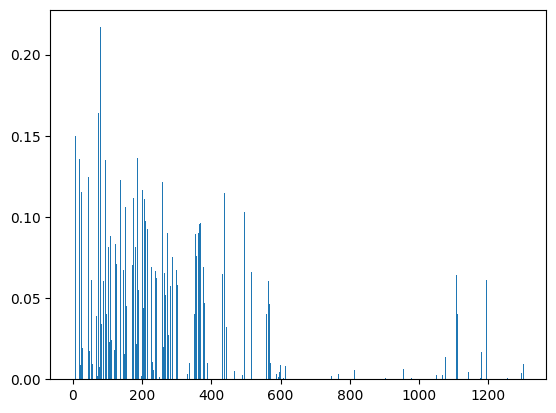

In [138]:
plt.bar(region_properties['label'],fieldfrac)

In [ ]:

posvox=arr_result[region_properties['label']-1]
allvox=region_properties['num_pixels'][region_properties['label']-1]
fieldfrac = posvox / allvox

In [132]:
arr_result.shape

(1326,)

4461.0

In [ ]:
#now make an image with ROI-based field tractions

#map atlas label to count
def atlas_to_count(

In [ ]:
with ProgressBar():
    arr_labels_ds=darr_labels_ds.compute()

[                                        ] | 1% Completed | 20.80 sms

In [ ]:

plt.subplot(1,2,1)
plt.imshow(darr[800,:,:], cmap="gray")
plt.axis("off")darr_labels_ds
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(arr_labelled[0,:,:])
plt.colorbar()
plt.axis("off")
plt.title("prediction + input overlay")

In [34]:
darr_atlas_ds4=da.from_zarr('spimquant/results/sub-mouse1/micr/sub-mouse1_sample-brain_acq-4x_stain-autof_from-ABAv3_desc-resampled_dseg.ome.zarr.zip',
                            component='/labels/dseg/1')
darr_atlas_ds4


dask.array<from-zarr, shape=(1616, 448, 378), dtype=uint16, chunksize=(1, 448, 378), chunktype=numpy.ndarray>

In [36]:
darr_ds4=da.from_zarr(zarr_autof,component='/4')
darr_ds4

dask.array<from-zarr, shape=(1616, 448, 378), dtype=>u2, chunksize=(1, 448, 378), chunktype=numpy.ndarray>

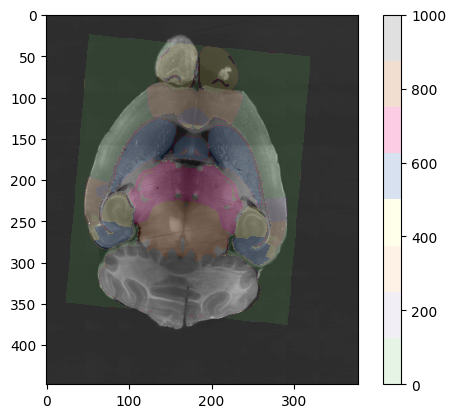

In [65]:
plt.imshow(darr_ds4[800,:,:].squeeze(),cmap='gray')
plt.imshow(darr_atlas_ds4[800,:,:].squeeze(),alpha=0.2,cmap='Accent',vmin=0,vmax=1000)
plt.colorbar()
#darr_atlas_ds4[800,:,:].n().compute()


In [59]:
zlbl = zarr.open('spimquant/results/sub-mouse1/micr/sub-mouse1_sample-brain_acq-4x_stain-autof_from-ABAv3_desc-resampled_dseg.ome.zarr.zip')
lbl_attrs = zlbl['/labels/dseg'].attrs.asdict()